### Natural Language Processing Project 

### Task: Question Answering using the FQuAD, French Question Answering Dataset

In [ ]:
### to reduce the long installation outputs
from IPython.display import clear_output


## importing dependencies
import json
from pathlib import Path
import zipfile

import tensorflow as tf
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

## word embedding model
import gensim

## filtering out warnings
import warnings
warnings.filterwarnings('ignore')

- The data used for the training is saved in [this github repository](https://github.com/IkeKobby/nlp_project/raw/main/used_data.zip).
 - In this project of question answering we shall employ the method of **text extraction** to retrieve answers to a given question given the context from which the question was asked.
 - The next cell below download the data into the directory `data` on colab for easy access. Kindly remove the hashtag if it is the first time you are using this notebook.
 - This project uses a smaller portion of the entire dataset due to inadequate resources for training fo the model. We utilised the Google provided GPU to aid with the dataset we have. 


In [ ]:
!mkdir data
!wget https://github.com/IkeKobby/nlp_project/raw/main/used_data.zip -O data/used_data.zip

unzip =zipfile.ZipFile('data/used_data.zip')
unzip.extractall('data/')
unzip.close()

clear_output()

In [ ]:
!wget https://raw.githubusercontent.com/IkeKobby/nlp_project/main/nlp_helper_functions.py
clear_output()

import nlp_helper_functions as helpers

## Global variables
- We used theswe global varibales to help with fine tuning of the model as and when deem necessary. 

In [ ]:
# TOKENIZATION
FILTERS = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
LOWER_CASE = True


# answer model parameters
EPOCHS = 100
BATCH_SIZE = 32
EMBED_SIZE = 200
CLASS_WEIGHTS = {0: 0.5, 1: 5.}

### Processed data

## This data has been preprocessed from the original data to fit into the model.
### A link to the helper functions for the various preprocessing we did shall be given access to in the github [link](https://raw.githubusercontent.com/IkeKobby/nlp_project/main/nlp_preoject_helper_functions.py). 


In [ ]:
## Data Loading and exploration
train_data = pd.read_csv('data/train_text.csv')
train_data.shape

(4500, 5)

In [ ]:
train_data.head(10)

,context,questions,answers,answer_start,answer_end
0,l'idée selon laquelle une planète inconnue pou...,quel astronome a émit l'idée en premier d'une ...,johann elert bode,23,26
1,l'idée selon laquelle une planète inconnue pou...,quel astronome découvrit uranus ?,william herschel,77,79
2,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,135,138
3,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,135,138
4,"piazzi observa cérès 24 fois, la dernière fois...",combien de fois piazzi est-il parvenu à observ...,24,3,4
5,"piazzi observa cérès 24 fois, la dernière fois...",où se trouvait barnaba oriani en 1801 ?,milan,35,36
6,"piazzi observa cérès 24 fois, la dernière fois...",dans quel revue scientifique fut publiées ces ...,monatliche correspondenz,105,107
7,"piazzi observa cérès 24 fois, la dernière fois...",pourquoi cérès n'était pas directement assimil...,son mouvement est lent et uniforme,49,55
8,"peu après sa découverte, cérès s'approcha trop...",pour quelle raison on ne put plus observer cér...,cérès s'approcha trop près du soleil,5,12
9,"peu après sa découverte, cérès s'approcha trop...",qui est parvenu à déterminer approximativement...,carl friedrich gauss,61,64


In [ ]:
train_data = helpers.fix_answer_index(train_data)

In [ ]:
## After fixing the indexes.
train_data.head(10)

,context,questions,answers,answer_start,answer_end
0,l'idée selon laquelle une planète inconnue pou...,quel astronome a émit l'idée en premier d'une ...,johann elert bode,22,25
1,l'idée selon laquelle une planète inconnue pou...,quel astronome découvrit uranus ?,william herschel,76,78
2,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,134,137
3,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,134,137
4,"piazzi observa cérès 24 fois, la dernière fois...",combien de fois piazzi est-il parvenu à observ...,24,2,3
5,"piazzi observa cérès 24 fois, la dernière fois...",où se trouvait barnaba oriani en 1801 ?,milan,34,35
6,"piazzi observa cérès 24 fois, la dernière fois...",dans quel revue scientifique fut publiées ces ...,monatliche correspondenz,104,106
7,"piazzi observa cérès 24 fois, la dernière fois...",pourquoi cérès n'était pas directement assimil...,son mouvement est lent et uniforme,48,54
8,"peu après sa découverte, cérès s'approcha trop...",pour quelle raison on ne put plus observer cér...,cérès s'approcha trop près du soleil,4,11
9,"peu après sa découverte, cérès s'approcha trop...",qui est parvenu à déterminer approximativement...,carl friedrich gauss,60,63


- We used 20% of the train data for validating the training of the model. However we used only 4500 from the entire dataset due to the cost of training large volume of data. The knowledge was however impacted:

In [ ]:
### dividing data  into train and validation sets.
train_data_ = train_data[:3600]
val_data = train_data.loc[3600:].reset_index(drop = True)
train_data_.shape, val_data.shape

((3600, 5), (900, 5))

In [ ]:
## retrieving the maximum sentence length from the context. 
def get_MAX_LEN(column):
  tok = []
  for sent in column:
    tok.append(len(sent.split()))
  get_max = max(np.array(tok))
  return get_max 

MAX_LEN = get_MAX_LEN(train_data.context)
MAX_LEN

503

In [ ]:
### A functionalized tokenizer that performs tokenization on the text columns of the data.
def define_tokenizer(df_series):
    sentences = pd.concat(df_series)
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters=FILTERS, 
        lower=LOWER_CASE
    )
    tokenizer.fit_on_texts(sentences)
    
    return tokenizer

## An encoder function that takes into effects the tokenized method and paired sentences and encode them numerically  
def encode(sentences, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(
        encoded_sentences, 
        padding='post',
        maxlen=MAX_LEN
    )
    
    return encoded_sentences

In [ ]:
## fitting the tokenizer with the required sentences
tokenizer = define_tokenizer([
    train_data_.context, 
    train_data_.questions,
    val_data.context, 
    val_data.questions
])

In [ ]:
### Getting the encodings for each sentences paired with respective questions. 
train_context = encode(train_data_.context.values, tokenizer)
train_questions = encode(train_data_.questions.values, tokenizer)

val_context = encode(val_data.context.values, tokenizer)
val_questions = encode(val_data.questions.values, tokenizer)

In [ ]:
## checking the encoding sizes
train_context.shape, train_questions.shape, val_context.shape, val_questions.shape

((3600, 503), (3600, 503), (900, 503), (900, 503))

In [ ]:
### A function that returns one-hot encoded labels for the output variables, thus, the start_tokens, end_tokens, in a dimension of the maximum sentence length
## With zeroes everywhere but for the position of the start and end tokens.

def form_answer_labels(df, sentence_length):
    start_labels = np.zeros((len(df), sentence_length))
    end_labels = np.zeros((len(df), sentence_length))

    for i in range(len(df)):
        start = df.loc[i].answer_start
        end = df.loc[i].answer_end

        if start < sentence_length and end < sentence_length:
            start_labels[i, start] = 1
            end_labels[i, end] = 1
        else:
            continue
    
    return start_labels, end_labels

### instantiating the function with the rewuired data.
train_start_labels, train_end_labels = form_answer_labels(train_data_, MAX_LEN)
val_start_labels, val_end_labels = form_answer_labels(val_data, MAX_LEN)

In [ ]:
### Printing out the representation of the start and end tokens in onehot encoded format.
print(train_data_.loc[0].context)
print('Start index: {0}'.format(train_start_labels[0]))
print('End index: {0}'.format(train_end_labels[0]))

l'idée selon laquelle une planète inconnue pourrait exister entre les orbites de mars et jupiter fut proposée pour la première fois par johann elert bode en 1768. ses suggestions étaient basées sur la loi de titius-bode, une théorie désormais obsolète proposée par johann daniel titius en 1766,. selon cette loi, le demi-grand axe de cette planète aurait été d'environ 2,8 ua. la découverte d'uranus par william herschel en 1781 accrut la confiance dans la loi de titius-bode et, en 1800, vingt-quatre astronomes expérimentés combinèrent leurs efforts et entreprirent une recherche méthodique de la planète proposée,. le groupe était dirigé par franz xaver von zach. bien qu'ils n'aient pas découvert cérès, ils trouvèrent néanmoins plusieurs autres astéroïdes.
Start index: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.

#### Model training 

In [ ]:
### We used LSTM for the training of the questions and answers.
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, Flatten

> We also trained an embedding on french texts to help with our french question answering task. A link to the text we trained the embedding on shall be provided [here](https://raw.githubusercontent.com/Ismailhachimi/French-Word-Embeddings/master/Data/data.txt). 

> The embedding shall also be added to the github repository for projects with French tasks. However, in the meantime here is a [google drive link](https://drive.google.com/drive/folders/1SEvX1tgw9PDg6JFZaXX7TDsSjKqtqwsK?usp=sharing) to the file on request for verification. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Using a trained model on french text
model_w2v = gensim.models.Word2Vec.load('/content/drive/MyDrive/models/nlp_cbow/w2v_cbow_200D')

### Create embedding dictionary for each french word from our dataset
embedding_dic = {}

for word in model_w2v.wv.vocab:
  embedding_dic[word] = model_w2v.wv.__getitem__(word)


num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, EMBED_SIZE))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dic.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

In [ ]:
## We built the model with the embedding layer on top of the LSTM

### embedding layer 
embedding = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    EMBED_SIZE,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

# encode question
question_input = Input(shape=(None,))
question_x = embedding(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(300, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(200, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)

# encode answer
answer_input = Input(shape=(None,))
answer_x = embedding(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(250, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(100, return_sequences=True))(answer_x)


# merge the encodings
combined_x = concatenate([question_x, answer_x])

# predict start index
start_x = Dropout(0.1)(combined_x) 
start_x = Conv1D(1,1)(start_x)
start_x = Flatten()(start_x)
start_x = Activation('softmax', name='start_token_out')(start_x)

# predict end index
end_x = Dropout(0.1)(combined_x) 
end_x = Conv1D(1,1)(end_x)
end_x = Flatten()(end_x)
end_x = Activation('softmax', name='end_token_out')(end_x)

# merge the parts into one model
model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=[start_x, end_x])

In [ ]:
## compiling the model with three metrics
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['categorical_accuracy', 'Recall', 'Precision']
)

## defining a call back to check with the model training and performance over time.
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [ ]:
### We fit the model and save the history for visualization and monitoring of the model performance
history = model.fit(
    x = [train_context, train_questions], 
    y = [train_start_labels, train_end_labels],
    validation_data = (
        [val_context, val_questions], 
        [val_start_labels, val_end_labels]
    ),
    epochs = EPOCHS,
    callbacks = callbacks,
    batch_size = BATCH_SIZE,
    shuffle = True
)

Epoch 1/100
113/113 [==============================] - 96s 435ms/step - loss: 9.7447 - start_token_out_loss: 4.8778 - end_token_out_loss: 4.8669 - start_token_out_categorical_accuracy: 0.0206 - start_token_out_recall: 0.0000e+00 - start_token_out_precision: 0.0000e+00 - end_token_out_categorical_accuracy: 0.0203 - end_token_out_recall_1: 0.0000e+00 - end_token_out_precision_1: 0.0000e+00 - val_loss: 9.4039 - val_start_token_out_loss: 4.6977 - val_end_token_out_loss: 4.7061 - val_start_token_out_categorical_accuracy: 0.0267 - val_start_token_out_recall: 0.0000e+00 - val_start_token_out_precision: 0.0000e+00 - val_end_token_out_categorical_accuracy: 0.0189 - val_end_token_out_recall_1: 0.0000e+00 - val_end_token_out_precision_1: 0.0000e+00
Epoch 2/100
113/113 [==============================] - 47s 420ms/step - loss: 9.5437 - start_token_out_loss: 4.7480 - end_token_out_loss: 4.7957 - start_token_out_categorical_accuracy: 0.0383 - start_token_out_recall: 0.0000e+00 - start_token_out_preci

In [ ]:
## We check for number of epochs and the best loss achieved.
print('Epoch: {0}'.format(len(history.history['loss'])))
print('Loss: {0}'.format(history.history['loss'][-1]))

Epoch: 50
Loss: 0.580427885055542


### Model Performance Visualizations 

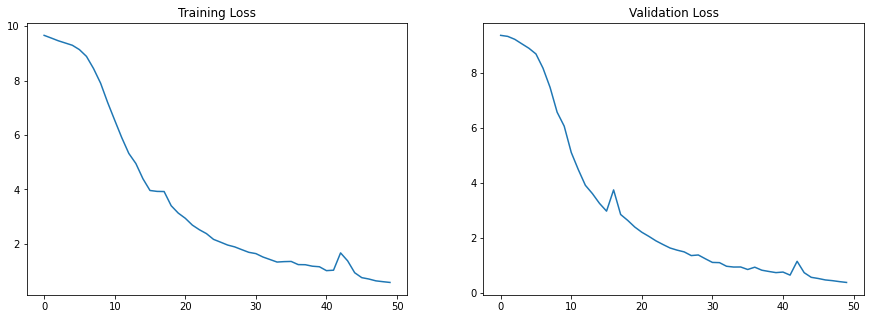

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

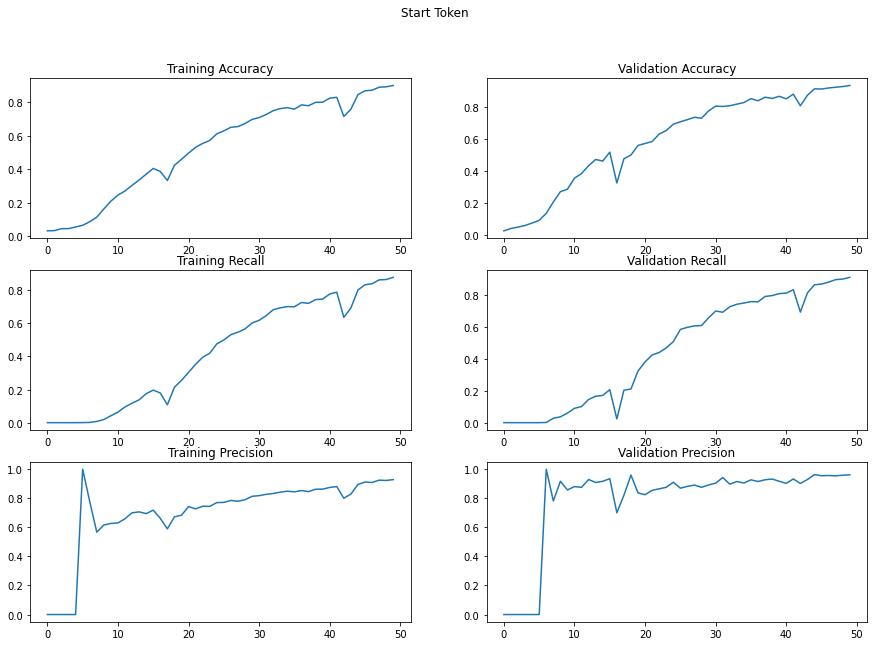

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('Start Token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['start_token_out_categorical_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_start_token_out_categorical_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['start_token_out_recall'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_start_token_out_recall'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['start_token_out_precision'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_start_token_out_precision'])
plt.show()

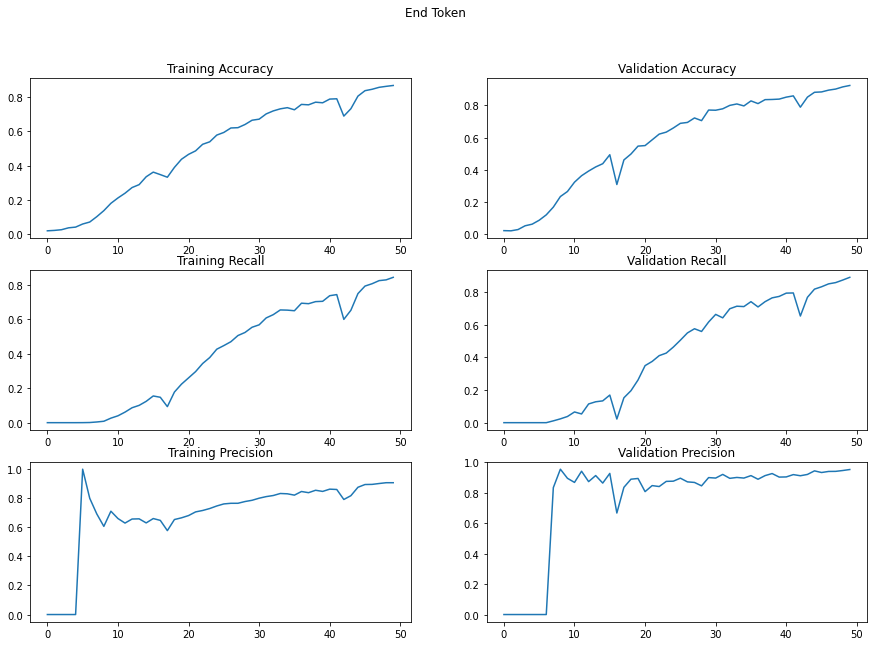

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('End Token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['end_token_out_categorical_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_end_token_out_categorical_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['end_token_out_recall_1'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_end_token_out_recall_1'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['end_token_out_precision_1'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_end_token_out_precision_1'])
plt.show()

# Validation Report on Start and End Tokens

In [ ]:
accuracy = history.history['start_token_out_categorical_accuracy'][-1]
recall = history.history['start_token_out_recall'][-1]
precision = history.history['start_token_out_precision'][-1]


print('Training')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

accuracy = history.history['end_token_out_categorical_accuracy'][-1]
recall = history.history['end_token_out_recall_1'][-1]
precision = history.history['end_token_out_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Training
Start token accuracy: 0.9006666541099548
Start token recall: 0.8764444589614868
Start token precision: 0.928218424320221
Start token F1 score: 0.9016
End token accuracy: 0.8704444169998169
End token recall: 0.8417778015136719
End token precision: 0.90687096118927
End token F1 score: 0.8731


# Validation Report

In [ ]:
accuracy = history.history['val_start_token_out_categorical_accuracy'][-1]
recall = history.history['val_start_token_out_recall'][-1]
precision = history.history['val_start_token_out_precision'][-1]


print('Validation')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

accuracy = history.history['val_end_token_out_categorical_accuracy'][-1]
recall = history.history['val_end_token_out_recall_1'][-1]
precision = history.history['val_end_token_out_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Validation
Start token accuracy: 0.9344444274902344
Start token recall: 0.9111111164093018
Start token precision: 0.961313009262085
Start token F1 score: 0.9355
End token accuracy: 0.9222221970558167
End token recall: 0.8888888955116272
End token precision: 0.9523809552192688
End token F1 score: 0.9195


#### Making Predictions to see how the model is performing

In [ ]:
def test_answer(question, context):
    sentences = [context, question]
    
    sentences = encode(sentences, tokenizer)
    
    predictions = model.predict(
        [np.expand_dims(sentences[0], axis=0), np.expand_dims(sentences[1], axis=0)]
    )
    
    predictions = np.array(predictions)
    
    pred_start = np.argmax(predictions[0,0])
    pred_end = np.argmax(predictions[1,0])
    pred_string = ' '.join(context.split(' ')[pred_start:pred_end])

    return pred_start, pred_end, pred_string

In [ ]:
context = train_data.context[4]
question = train_data.questions[4]

In [ ]:
question

'combien de fois piazzi est-il parvenu à observer cérès ?'

In [ ]:
start, end, answer = test_answer(question, context)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + answer)

Start token: 3
End token: 4
Answer: 24


## Conclusion 

- It took us a lot of time trying to figure out how to tuckle the problem statement. Although, the beginning of the task was somewhat cumbersome we consulted some online resources like [kaggle](https://www.kaggle.com/), [hugging face](https://huggingface.co/), [tensorflow hub](http://tfhub.dev/) and many others to show us the way. 
- Although, BERT has proven to work well with the question answering tasks, due to the knowledge we seek to get from the project we conformed to going through the many mini steps, even from preprocessing of a json complex dataset into a more simpler one to feed into a neural network after several cleaning preprocesses. BERT, we considered to fall into the "Black Box" tasks and not much knowledge is retrieved as you learn through.